

Demo Goals: Building a RAG-based Movie Chatbot

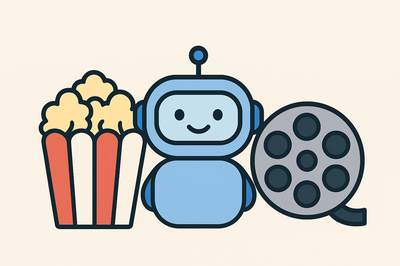

This notebook showcases a proof of concept for a conversational movie assistant using Retrieval-Augmented Generation (RAG). The aim is to create a chatbot that understands natural language and helps users discover movies from an IMDb dataset.

What This Chatbot Can Do:
Chat-based Movie Search – Ask about movies by genre, actors, plot summaries, or reviews.

Smart Recommendations – Get personalized movie suggestions based on your preferences.

Instant Movie Info – View ratings, reviews, and summaries instantly—no manual searching required.

The goal is to explore how AI can make movie discovery more natural, fast, and fun.

Done and done.



In [1]:
# Importing the OpenAI library to interact with OpenAI's API services.
import openai

# Import basic libraries
import os
import json
import pandas as pd
import numpy as np
import faiss
import gradio as gr
import requests
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from sentence_transformers import SentenceTransformer
from typing import List, Dict


c:\Users\bill\repos\MovieFinder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Try to get API key from environment
api_key = os.getenv("OPENAI_API_KEY")

# If not set, prompt the user
if not api_key:
    api_key = input("Please enter your OpenAI API key: ")

openai.api_key = api_key


In [4]:
# Read data source and get summary values
df = pd.read_csv('IMDb_Dataset_Composite_Cleaned.csv')

# Check for null values in each column
print(df.isnull().sum())

# Get a summary of the DataFrame
print(df.info())

# Show unique values per column
print(df.nunique())

Title                 0
IMDb Rating           0
Year                  0
Certificates          0
Director              0
Star Cast             0
MetaScore             0
Duration (minutes)    0
Poster-src            0
Genres                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               3653 non-null   object 
 1   IMDb Rating         3653 non-null   float64
 2   Year                3653 non-null   int64  
 3   Certificates        3653 non-null   object 
 4   Director            3653 non-null   object 
 5   Star Cast           3653 non-null   object 
 6   MetaScore           3653 non-null   float64
 7   Duration (minutes)  3653 non-null   float64
 8   Poster-src          3653 non-null   object 
 9   Genres              3653 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage

In [5]:
# Create movie description for each movie from the details provided in the dataset
def generate_description(row):
    title = row['Title']
    year = int(row['Year'])
    genres = row['Genres']
    director = row['Director']
    star_cast = format_star_cast(row['Star Cast'])
    rating = row['IMDb Rating']
    duration = int(row['Duration (minutes)'])
    certificate = row['Certificates']
    metascore = row['MetaScore']
    # Description template
    description = (
        f"{title} ({year}) is a {genres.lower()} film directed by {director}. "
        f"Featuring {star_cast}, this movie has an IMDb rating of {rating}/10 and a MetaScore of {metascore}. "
        f"With a runtime of {duration} minutes, it is"
        f" rated {certificate}."
    )
    return description

# Format star cast
def format_star_cast(star_cast):
    # Split by commas and strip whitespace
    actors = [actor.strip() for actor in star_cast.split(',')]
    if len(actors) > 3:
        return ", ".join(actors[:3]) + ", and others"
    return ", ".join(actors)

# Main function
def create_movie_descriptions(output_file):
    # Generate descriptions
    descriptions = []
    for _, row in df.iterrows():
        desc = generate_description(row)
        descriptions.append({'Title': row['Title'], 'Description': desc})

    # Save to CSV
    desc_df = pd.DataFrame(descriptions)
    desc_df.to_csv(output_file, index=False)
    print(f"Descriptions saved to {output_file}")

    # Print first five descriptions
    for _, row in desc_df.head(5).iterrows():
        print(f"\nTitle: {row['Title']}\nDescription: {row['Description']}\n")


# Run the script
output_file = 'Movie_Descriptions.csv'
create_movie_descriptions(output_file)

Descriptions saved to Movie_Descriptions.csv

Title: Gladiator
Description: Gladiator (2000) is a action film directed by Ridley Scott. Featuring David Franzoni, John Logan, William Nicholson, this movie has an IMDb rating of 8.5/10 and a MetaScore of 67.0. With a runtime of 155 minutes, it is rated R.


Title: Mission: Impossible - Dead Reckoning Part One
Description: Mission: Impossible - Dead Reckoning Part One (2023) is a action film directed by Christopher McQuarrie. Featuring Tom Cruise, Hayley Atwell, Ving Rhames, this movie has an IMDb rating of 7.7/10 and a MetaScore of 81.0. With a runtime of 163 minutes, it is rated PG-13.


Title: Inglourious Basterds
Description: Inglourious Basterds (2009) is a adventure film directed by Quentin Tarantino. Featuring Brad Pitt, Diane Kruger, Eli Roth, this movie has an IMDb rating of 8.4/10 and a MetaScore of 69.0. With a runtime of 153 minutes, it is rated R.


Title: The Lord of the Rings: The Fellowship of the Ring
Description: The Lord

In [6]:
# Load the CSV file
df = pd.read_csv('Movie_Descriptions.csv')

# Inspect the first few rows
print(df.head())
print(f"Number of movies: {len(df)}")

                                               Title  \
0                                          Gladiator   
1      Mission: Impossible - Dead Reckoning Part One   
2                               Inglourious Basterds   
3  The Lord of the Rings: The Fellowship of the Ring   
4                                             Damsel   

                                         Description  
0  Gladiator (2000) is a action film directed by ...  
1  Mission: Impossible - Dead Reckoning Part One ...  
2  Inglourious Basterds (2009) is a adventure fil...  
3  The Lord of the Rings: The Fellowship of the R...  
4  Damsel (2024) is a action film directed by Jua...  
Number of movies: 3653


In [7]:
# Now, data is ready!
# Its time to create your vector store
# Perform Text Chunking

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,  # Small chunk size due to short descriptions
    chunk_overlap=20,  # Small overlap to preserve context
    length_function=len,
)

# Split descriptions into chunks and store with metadata
chunks = []
for _idx, row in df.iterrows():
    split_texts = text_splitter.split_text(row['Description'])
    for chunk in split_texts:
        chunks.append({
            'Title': row['Title'],
            'Chunk': chunk,
            'Metadata': {
                'Title': row['Title']
                # Add more metadata if needed, e.g., extract year, genre from Description
            }
        })

# Convert chunks to a DataFrame
chunks_df = pd.DataFrame(chunks)
print(chunks_df.head())
print(f"Total chunks: {len(chunks_df)}")

                                           Title  \
0                                      Gladiator   
1                                      Gladiator   
2  Mission: Impossible - Dead Reckoning Part One   
3  Mission: Impossible - Dead Reckoning Part One   
4                           Inglourious Basterds   

                                               Chunk  \
0  Gladiator (2000) is a action film directed by ...   
1      With a runtime of 155 minutes, it is rated R.   
2  Mission: Impossible - Dead Reckoning Part One ...   
3  of 7.7/10 and a MetaScore of 81.0. With a runt...   
4  Inglourious Basterds (2009) is a adventure fil...   

                                            Metadata  
0                             {'Title': 'Gladiator'}  
1                             {'Title': 'Gladiator'}  
2  {'Title': 'Mission: Impossible - Dead Reckonin...  
3  {'Title': 'Mission: Impossible - Dead Reckonin...  
4                  {'Title': 'Inglourious Basterds'}  
Total chunks: 7225


In [8]:
# Create embeddings for the chunks
# See https://python.langchain.com/docs/integrations/text_embedding/ for a list of available embedding models on LangChain

# Load the embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# or use 'all-MiniLM-L12-v2' for a larger model
# or for higher quality (at the cost of speed), use all-mpnet-base-v2.

# Generate embeddings for all chunks
embeddings = embedding_model.encode(chunks_df['Chunk'].tolist(), show_progress_bar=True)

# Add embeddings to the DataFrame
chunks_df['Embedding'] = embeddings.tolist()
print(chunks_df[['Title', 'Chunk', 'Embedding']].head())


# Convert embeddings to a numpy array
embedding_matrix = np.array(chunks_df['Embedding'].tolist(), dtype=np.float32)

# Initialize FAISS index
dimension = embedding_matrix.shape[1]  # Embedding dimension (384 for all-MiniLM-L6-v2)
index = faiss.IndexFlatL2(dimension)  # L2 distance for similarity search
index.add(embedding_matrix)  # Add embeddings to the index

# Save the FAISS index
faiss.write_index(index, 'movie_vector_store.index')

# Save chunks and metadata for retrieval
chunks_df[['Title', 'Chunk', 'Metadata']].to_csv('movie_chunks_metadata.csv', index=False)
print("FAISS vector store created and saved.")

Batches: 100%|██████████| 226/226 [00:30<00:00,  7.53it/s]


                                           Title  \
0                                      Gladiator   
1                                      Gladiator   
2  Mission: Impossible - Dead Reckoning Part One   
3  Mission: Impossible - Dead Reckoning Part One   
4                           Inglourious Basterds   

                                               Chunk  \
0  Gladiator (2000) is a action film directed by ...   
1      With a runtime of 155 minutes, it is rated R.   
2  Mission: Impossible - Dead Reckoning Part One ...   
3  of 7.7/10 and a MetaScore of 81.0. With a runt...   
4  Inglourious Basterds (2009) is a adventure fil...   

                                           Embedding  
0  [-0.05790012702345848, -0.014515863731503487, ...  
1  [0.0352526493370533, -0.008303035981953144, -0...  
2  [-0.10678184032440186, -0.053367096930742264, ...  
3  [0.00942922756075859, -0.008778041228652, -0.0...  
4  [-0.021513326093554497, -0.06901950389146805, ...  
FAISS vector store c

In [9]:
# Create a vector store using the created chunks and the embeddings model

# Load the FAISS index
index = faiss.read_index('movie_vector_store.index')

# Load metadata
chunks_df = pd.read_csv('movie_chunks_metadata.csv')

# Load embedding model (must match vector store)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to search the FAISS vector store


def search_vector_store(query, k=5):
    query_embedding = embedding_model.encode([query])[0]
    query_embedding = np.array([query_embedding], dtype=np.float32)
    distances, indices = index.search(query_embedding, k)
    results = []
    for idx in indices[0]:
        result = chunks_df.iloc[idx]
        # Handle Metadata as string (if saved as string in CSV)
        metadata = eval(result['Metadata']) if isinstance(result['Metadata'], str) else result['Metadata']
        results.append({
            'Title': result['Title'],
            'Chunk': result['Chunk'],
            'Metadata': metadata
        })
    return results

In [10]:
# Query the FAISS index
query_text = "Documentary about a famous person"
query_embedding = embedding_model.encode([query_text])[0]
query_embedding = np.array([query_embedding], dtype=np.float32)

# Search for top 5 similar chunks
k = 5
distances, indices = index.search(query_embedding, k)

# Retrieve results
for idx in indices[0]:
    print(f"Title: {chunks_df.iloc[idx]['Title']}")
    print(f"Chunk: {chunks_df.iloc[idx]['Chunk']}")
    print(f"Metadata: {chunks_df.iloc[idx]['Metadata']}")
    print("-" * 50)

Title: The People's Story
Chunk: The People's Story (2000) is a documentary film directed by Steven Scaffidi. Featuring Daniel Radcliffe, Emma Watson, Rupert Grint, this movie has an IMDb rating of 9.5/10 and a MetaScore of 66.0.
Metadata: {'Title': "The People's Story"}
--------------------------------------------------
Title: Eva Hesse
Chunk: Eva Hesse (2016) is a documentary film directed by Marcie Begleiter. Featuring Selma Blair, Bob Balaban, Patrick Kennedy, this movie has an IMDb rating of 7.1/10 and a MetaScore of 69.0. With a
Metadata: {'Title': 'Eva Hesse'}
--------------------------------------------------
Title: The Kingmaker
Chunk: The Kingmaker (2019) is a documentary film directed by Lauren Greenfield. Featuring Imelda Marcos, Etta Rosales, Ferdinand Marcos, this movie has an IMDb rating of 7.6/10 and a MetaScore of 76.0. With
Metadata: {'Title': 'The Kingmaker'}
--------------------------------------------------
Title: Fauci
Chunk: Fauci (2021) is a documentary film dir

In [11]:
# Create the llm model

# Initialize GPT-3.5-turbo
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0.7,  # Controls creativity
    max_tokens=512,   # Max response tokens
    openai_api_key=os.environ.get("OPENAI_API_KEY")
)

In [12]:
# Create the prompt template
prompt_template = """
You are a movie expert. Based on the following movie descriptions, 
answer the user's query as accurately and concisely as possible. 
If the information is insufficient, say so.

**Query**: {query}

**Context**:
{context}

**Answer**:
"""
prompt = PromptTemplate.from_template(prompt_template)

# Create the document processing chain
def format_docs(results):
    return "\n\n".join([f"Title: {res['Title']}\nDescription: {res['Chunk']}" for res in results])

# Create RAG chain
rag_chain = (
    {"context": lambda x: format_docs(search_vector_store(x['query'])), "query": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Test the pipeline
query = "Recommend a documentary about a famous person"
response = rag_chain.invoke({"query": query})
print(f"Query: {query}")
print(f"Response: {response}")

Query: Recommend a documentary about a famous person
Response: I would recommend the documentary "Fauci" (2021) directed by John Hoffman, which focuses on the famous person Dr. Anthony Fauci.


In [13]:
# Invoke the retrieval chain to process the user's query
def movie_recommendation(query):
    try:
        # Invoke the RAG chain with the user's query
        response = rag_chain.invoke({"query": query})
        return response
    except Exception as e:
        return f"Error: {str(e)}"
    

    
# Test the pipeline
query = "Recommend a documentary about a famous person"
response = movie_recommendation(query)
print(f"Query: {query}")
print(f"Response: {response}")

Query: Recommend a documentary about a famous person
Response: I recommend the documentary "Fauci" (2021) directed by John Hoffman, featuring Bono George W. Bush Francis, and others. It has an IMDb rating of 6.5/10 and a MetaScore of 70.0.


In [14]:
# Test the functionality using a Gradio UI (intermediate check)

# Define the Gradio interface
iface = gr.Interface(
    fn=movie_recommendation,
    inputs=gr.Textbox(lines=2, placeholder="Enter your movie query (e.g., 'Recommend a documentary about a famous person')"),
    outputs="text",
    title="Movie Recommendation Bot",
    description="Ask for movie recommendations or information based on a dataset of IMDb movies. Powered by a RAG system with FAISS and OpenAI's GPT-3.5-turbo."
)

# Launch the interface
iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [20]:
# Define various agents - each performing a particular task using tool decorator

# MovieRetrieverAgent: Retrieves movies from FAISS vector store
class MovieRetrieverAgent:
    @tool
    def retrieve_movies(query: str, top_k: int = 5) -> List[Dict]:
        """Retrieve movies from the FAISS vector store based on a query."""
        if not query.strip():
            return {"error": "Query cannot be empty"}
        try:
            query_embedding = embedding_model.encode([query])[0]
            query_embedding = np.array([query_embedding], dtype=np.float32)
            distances, indices = index.search(query_embedding, top_k)
            results = []
            for idx in indices[0]:
                result = chunks_df.iloc[idx]
                metadata = eval(result['Metadata']) if isinstance(result['Metadata'], str) else result['Metadata']
                results.append({
                    "title": metadata.get("Title"),
                    "description": result['Chunk'],
                    "metadata": metadata
                })
            return results if results else {"error": "No movies found"}
        except Exception as e:
            return {"error": f"Retrieval error: {str(e)}"}

class ExternalDataAgent:
    @tool
    def fetch_movie_ratings(title: str) -> Dict:
        """Fetch movie ratings from the OMDB API."""
        if not title.strip():
            return {"error": "Movie title cannot be empty"}

        # Get API key from environment variable or prompt user
        api_key = os.environ.get("OMDB_API_KEY")
        if not api_key:
            api_key = input("Please enter your OMDB API key: ")
            if not api_key:
                return {"error": "OMDB API key is required"}

        # OMDB API endpoint
        url = "http://www.omdbapi.com/"
        params = {
            "t": title, 
            "apikey": api_key,
            "plot": "full",  # Full plot for more details}
        }
        
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()  # Raise exception for bad status codes
            data = response.json()

            # Check if API returned a valid response
            if data.get("Response") == "True":
                return {
                    "title": data.get("Title", title),
                    "imdb_rating": data.get("imdbRating", "N/A"),
                    "source": "OMDB API",
                    "year": data.get("Year", "N/A"),
                    "metascore": data.get("Metascore", "N/A"), 
                    "plot": data.get("Plot", "N/A"),
                    "actors": data.get("Actors", "N/A")
                }
            else:
                return {"error": f"Movie not found: {data.get('Error', 'Unknown error')}"}

        except requests.RequestException as e:
            return {"error": f"OMDB API request failed: {str(e)}"}
        except ValueError as e:
            return {"error": f"Invalid response from OMDB API: {str(e)}"}
        except Exception as e:
            return {"error": f"Unexpected error: {str(e)}"}


# RecommendationAgent: Generates recommendations based on query
class RecommendationAgent:
    @tool
    def recommend_movies(query: str, top_k: int = 3) -> List[Dict]:
        """Generate movie recommendations based on the query."""
        if not query.strip():
            return {"error": "Query cannot be empty"}
        try:
            # Retrieve movies
            retrieved = MovieRetrieverAgent.retrieve_movies.invoke({"query": query, "top_k": 5})
            if "error" in retrieved:
                return retrieved

            # Generate recommendations
            prompt_template = """
            You are a movie expert. Based on the user query: '{query}',
            recommend {top_k} movies from the following list:
            {movies}
            Provide a brief reason for each recommendation.
            """
            prompt = PromptTemplate.from_template(prompt_template)
            movies_str = "\n".join([f"{m['title']}: {m['description']}" for m in retrieved])
            chain = prompt | llm | StrOutputParser()
            response = chain.invoke({
                "query": query,
                "top_k": top_k,
                "movies": movies_str
            })

            # Parse response
            recommendations = []
            for line in response.split("\n")[:top_k]:
                if line.strip() and ":" in line:
                    title, reason = line.split(":", 1)
                    recommendations.append({"title": title.strip(), "reason": reason.strip()})
            return recommendations if recommendations else {"error": "No recommendations generated"}
        except Exception as e:
            return {"error": f"Recommendation error: {str(e)}"}



In [22]:
# Define the orchestrator logic to run the agents appropriately
class MovieRecommendationOrchestrator:
    def __init__(self):
        self.retriever = MovieRetrieverAgent()
        self.recommender = RecommendationAgent()
        # self.external_data = ExternalDataAgent()

    def process_query(self, query: str, top_k: int = 3) -> Dict:
        """Orchestrate the recommendation process."""
        try:
            # Step 1: Retrieve movies
            retrieved = self.retriever.retrieve_movies.invoke({"query": query, "top_k": 5})
            if "error" in retrieved:
                return {"error": retrieved["error"], "recommendations": [], "ratings": []}

            # Step 2: Generate recommendations
            recommendations = self.recommender.recommend_movies.invoke({
                "query": query,
                "top_k": top_k
            })
            if "error" in recommendations:
                return {"error": recommendations["error"], "recommendations": [], "ratings": []}
            return recommendations
        except Exception as e:
            return {"error": f"Orchestration error: {str(e)}", "recommendations": [], "ratings": []}

In [23]:
# Create a UI using Gradio

import gradio as gr
import json

# Gradio UI
def gradio_interface(query: str):
    orchestrator = MovieRecommendationOrchestrator()

    # Process query
    result = orchestrator.process_query(query)

    # Handle error case
    if isinstance(result, dict) and "error" in result:
        return f"Error: {result['error']}"

    # Format output for recommendations
    output = "**Recommendations**:\n"
    for rec in result:
        output += f"- {rec['title']}: {rec['reason']}\n"
    return output

# Launch Gradio UI
def launch_ui():
    with gr.Blocks() as demo:
        gr.Markdown("# Movie Recommender")
        query = gr.Textbox(label="Query (e.g., 'Documentary about a famous person')")
        submit = gr.Button("Get Recommendations")
        output = gr.Textbox(label="Results")
        submit.click(
            fn=gradio_interface,
            inputs=[query],
            outputs=output
        )
    demo.launch(server_name="127.0.0.1", server_port=7862)

# Example usage (for testing without UI)
if __name__ == "__main__":
    orchestrator = MovieRecommendationOrchestrator()
    result = orchestrator.process_query("Documentary about a famous person")
    print(json.dumps(result, indent=2))
    launch_ui()

[
  {
    "title": "1. The People's Story",
    "reason": "This documentary features famous actors Daniel Radcliffe, Emma Watson, and Rupert Grint, known for their roles in the Harry Potter franchise. It provides an insight into their lives and experiences, making it a compelling watch for fans and those interested in their journey to stardom."
  },
  {
    "title": "2. Eva Hesse",
    "reason": "This documentary focuses on the life of the famous artist Eva Hesse, known for her innovative and influential work in the art world. It offers a deep dive into her personal struggles and artistic vision, making it a fascinating exploration of her life and legacy."
  }
]
* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
